In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from keras import backend as K
from ndac.data_processing import quantile_classify, encode_sequence, value_classify
from ndac.predict import train_clstm
from sklearn.model_selection import train_test_split

In [11]:
# read in sequence/property data
data = pd.read_csv('dataframes/DF_prest.csv', index_col=0)

# train with amino acid sequence

45206 samples input.
11302 samples in class 0
11301 samples in class 1
22603 samples removed.


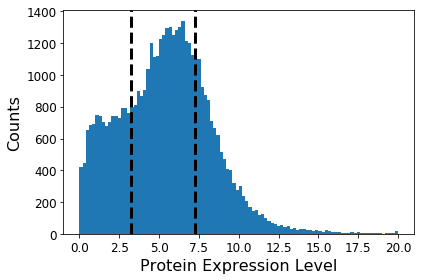

In [12]:
df, hist = quantile_classify(data['conc_cf'], data['aa_seq'],
                             [0.25, 0.75], drop_class=[1])
X, y = encode_sequence(df['aa_seq'], df['class'],
                       max_length=200)

In [13]:
aa_model = train_clstm(X, y, test_fraction=0.3, epochs=15)

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 10)           210       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 200, 128)          3968      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 100, 128)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               91600     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 95,879
Trainable params: 95,879
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/15
15822/15822 [==========================

In [15]:
aa_model.save('visualize_training_model.h5')

In [17]:
X = pd.DataFrame(X, index=df.index)
y = pd.Series(y, index=df.index)

# fix random seed for reproducibility
np.random.seed(7)

X_train, X_test, y, y_test = train_test_split(X, y, test_size=0.3)

y_pred = aa_model.predict(X_test.values).round()

new_data = pd.DataFrame(np.zeros((len(y_test), 3)), index=X_test.index,
                        columns=['conc_cf', 'y_true', 'y_pred'])
new_data['conc_cf'] = df.loc[X_test.index, 'conc_cf'].values
new_data['y_true'] = y_test.values
new_data['y_pred'] = y_pred
new_data['correct'] = np.equal(new_data['y_true'], new_data['y_pred'])

In [41]:
x1 = new_data.loc[new_data['correct'] == True, 'conc_cf'].values
x2 = new_data.loc[new_data['correct'] == False, 'conc_cf'].values
x3 = data.loc[np.isin(data.index, new_data.index, invert=True), 'conc_cf']

/Users/joshsmith/Git/NovoNordisk_Capstone/.env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


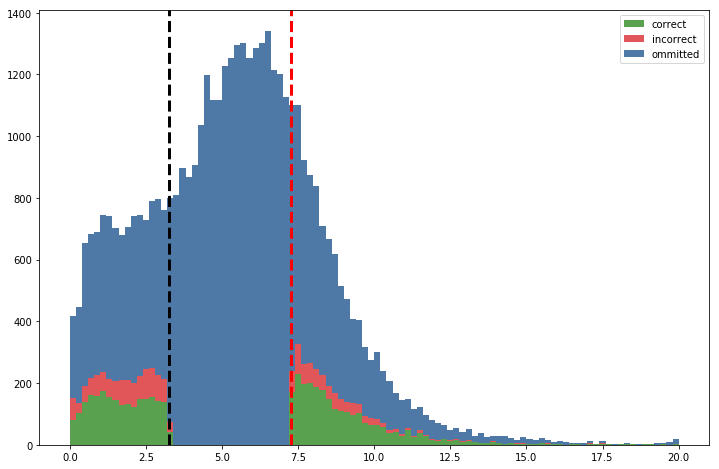

In [54]:
#Stack the data
low = data['conc_cf'].quantile(0.25)
high = data['conc_cf'].quantile(0.75)
pal = ['#59a14f', '#e15759', '#4e79a7']


plt.figure(figsize=(12, 8))
plt.hist([x1, x2, x3], 100, stacked=True, color=pal)
plt.legend(['correct', 'incorrect', 'ommitted'])
plt.axvline(low, color='k', linestyle='dashed', linewidth=3)
plt.axvline(high, color='r', linestyle='dashed', linewidth=3)
plt.show()

In [48]:
data.loc[X_test.index, 'conc_cf'].values

array([5.6524, 2.2203, 7.32  , ..., 6.8834, 1.88  , 2.6073])

# expression multiclass

45206 samples input.
11302 samples in class 0
22603 samples in class 1
11301 samples in class 2
0 samples removed.


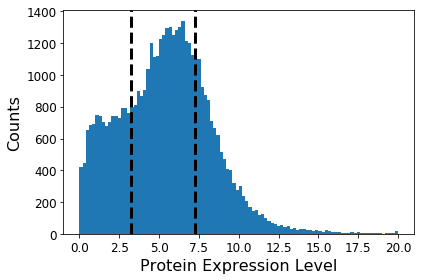

In [56]:
df, hist = quantile_classify(data['conc_cf'], data['aa_seq'],
                             [0.25, 0.75])
X, y = encode_sequence(df['aa_seq'], df['class'],
                       max_length=200)

In [57]:
aa_model = train_clstm(X, y, test_fraction=0.3, epochs=15)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 200, 10)           210       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 200, 128)          3968      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 100, 128)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               91600     
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 303       
Total params: 96,081
Trainable params: 96,081
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/15
31644/31644 [==============================] - 59s 2ms/step - loss: 1.0347 - acc: 0.5026
Epoch 2/15
31644/31644 [=========

In [59]:
X = pd.DataFrame(X, index=df.index)
y = pd.DataFrame(y, index=df.index)

# fix random seed for reproducibility
np.random.seed(7)

X_train, X_test, y, y_test = train_test_split(X, y, test_size=0.3)

In [68]:
y_pred = aa_model.predict(X_test.values).round()

new_data = pd.DataFrame(np.zeros((len(y_test), 3)), index=X_test.index,
                        columns=['conc_cf', 'y_true', 'y_pred'])
new_data['conc_cf'] = df.loc[X_test.index, 'conc_cf'].values

new_data['y_true'] = np.argmax(y_test.values, axis=1)
new_data['y_pred'] = np.argmax(y_pred, axis=1)
new_data['correct'] = np.equal(new_data['y_true'], new_data['y_pred'])

/Users/joshsmith/Git/NovoNordisk_Capstone/.env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


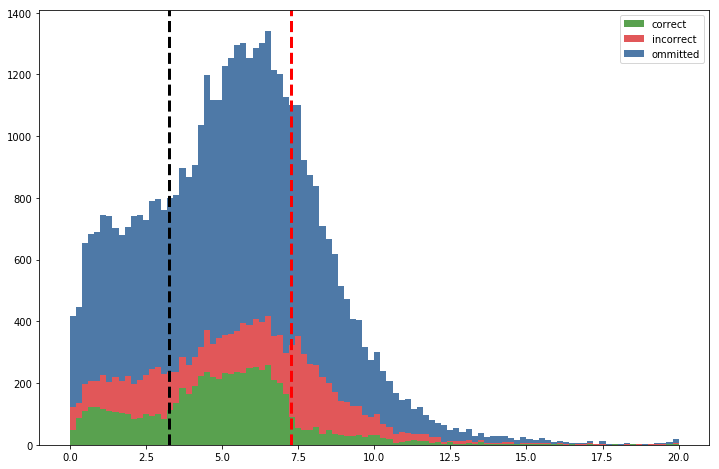

In [72]:
x1 = new_data.loc[new_data['correct'] == True, 'conc_cf'].values
x2 = new_data.loc[new_data['correct'] == False, 'conc_cf'].values
x3 = data.loc[np.isin(data.index, new_data.index, invert=True), 'conc_cf']

#Stack the data
low = data['conc_cf'].quantile(0.25)
high = data['conc_cf'].quantile(0.75)
pal = ['#59a14f', '#e15759', '#4e79a7']


plt.figure(figsize=(12, 8))
plt.hist([x1, x2, x3], 100, stacked=True, color=pal)
plt.legend(['correct', 'incorrect', 'ommitted'])
plt.axvline(low, color='k', linestyle='dashed', linewidth=3)
plt.axvline(high, color='r', linestyle='dashed', linewidth=3)
plt.show()

# solubility multiclass

In [18]:
# read in sequence/property data
data = pd.read_csv('dataframes/DF_solubility.csv', index_col=0)

16082 samples input.
3324 samples in class 0
7667 samples in class 1
5091 samples removed.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 200, 4)            84        
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 200, 128)          1664      
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 100, 128)          0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 100)               91600     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 101       
Total params: 93,449
Trainable params: 93,449
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/1
7693/7693 [=====================

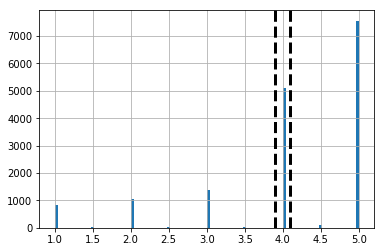

In [20]:
df, hist = value_classify(data['solubility_class_1M'], data['aa_seq'],
                             [3.9, 4.1], drop_class=[1])
X, y = encode_sequence(df['aa_seq'], df['class'],
                       max_length=200)
aa_model = train_clstm(X, y, test_fraction=0.3, epochs=1)

16082 samples input.
838 samples in class 0
1071 samples in class 1
1394 samples in class 2
5112 samples in class 3
7667 samples in class 4
0 samples removed.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 200, 4)            84        
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 200, 128)          1664      
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 100, 128)          0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 100)               91600     
_________________________________________________________________
dense_8 (Dense)              (None, 5)                 505       
Total params: 93,853
Trainable params: 93,853
Non-trainable params: 0
_____________________________________________

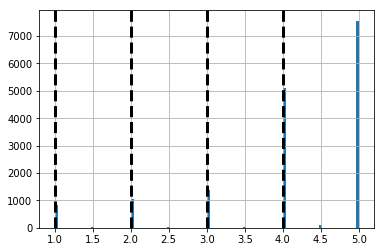

In [22]:
df, hist = value_classify(data['solubility_class_1M'], data['aa_seq'],
                             [1, 2, 3, 4])
X, y = encode_sequence(df['aa_seq'], df['class'],
                       max_length=200)
aa_model = train_clstm(X, y, test_fraction=0.3, epochs=1)